# Swaption Calibration

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Import Data](#p1)

# [2. Displaced Diffusion Model](#p2)
## [- Sigma](#p2a)
## [- Beta](#p2b)

# [3. SABR Model](#p3)
## [- Alpha](#p3a)
## [- Nu](#p3b)
## [- Rho](#p3c)

# [4. Check Calibration](#p4)

# [5. Pricing Swaptions](#p5)
## [- Payer 2y x 10y](#p5a)
## [- Receiver 8y x 10y](#p5b)

In [1]:
import math
import numpy as np
import scipy.stats as si
from scipy.stats import norm
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import pandas as pd
import datetime as dt

from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import least_squares

import warnings
warnings.filterwarnings('ignore') 

# <a id = "p1">1.</a>  <font color = "green"> Import Data </font>  [back to table of contents](#top)

In [2]:
IRS_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="IRS",
                         usecols="A:C")

OIS_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="OIS",
                         usecols="A:C")

Swaption_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="Swaption",
                         usecols="A:M",
                         skiprows=2)

Forward_rate = pd.read_csv("Forward_swap_rates_df.csv")
Discount_Factors = pd.read_csv("Discount_Factors.csv")

In [3]:
# ATM is forward_swap_rates, the other values are ATM forward_swap_rates adjusted accordingly

df_strike = pd.DataFrame()
bps = np.array([-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200])/1e4
for i in list(Forward_rate["Forward_Swap_Rates"]):
    df_strike = pd.concat([df_strike, pd.DataFrame(i+bps)], axis = 1)
df_strike.index = Swaption_data.columns[2:13]
df_strike.columns = [(x,y) for x, y in zip(Swaption_data["Expiry"], Swaption_data["Tenor"])]

# <a id = "p2">2.</a>  <font color = "green"> Displaced Diffusion Model </font>  [back to table of contents](#top)

In [4]:
pd.concat([Swaption_data[["Expiry", "Tenor"]],
           Swaption_data["ATM"]/100],
          axis=1)

,Expiry,Tenor,ATM
0,1Y,1Y,0.2250
1,1Y,2Y,0.2872
2,1Y,3Y,0.2978
3,1Y,5Y,0.2607
4,1Y,10Y,0.2447
5,5Y,1Y,0.2726
6,5Y,2Y,0.2983
7,5Y,3Y,0.2998
8,5Y,5Y,0.2660
9,5Y,10Y,0.2451


### Explanation

- The swap begins accruing from the **first coupon date**, which is 0.5 years after $$ t_{\text{begin}} $$
- We find all discount factors between $$ t_{\text{begin}} + 0.5 $$ and $$ t_{\text{end}} $$
- Since payments are made **semi-annually**, we multiply each discount factor by **0.5**.
- The PVBP is the sum of these adjusted discount factors.

---

### Formula

$$
\text{PVBP} = 0.5 \sum_{i = t_{\text{begin}} + 0.5}^{t_{\text{end}}} D(0, t_i)
$$

Where:

- \( D(0, $t_i$) \): OIS discount factor at time \( $t_i$ \)
- Payments are assumed to be made every **0.5 years (semi-annually)**

In [6]:
def calc_pvbp(t_begin, 
              t_end):
    index_start = Discount_Factors[Discount_Factors["Years"] == t_begin+0.5].index[0]
    
    index_end = Discount_Factors[Discount_Factors["Years"] == t_end].index[0]
    
    discount_window = Discount_Factors.loc[index_start:index_end, "OIS_Discount_Factor"]

    pvbp = sum(0.5*discount_window)
    
    return pvbp

### Black 76 Payer Swaption Formula

This function calculates the price of the European payer swaption using the **Black 1976 model**. It prices the right to pay fixed and receive floating in an interest rate swap.

#### Function Logic

- **`pvbp`**: Present value of a basis point, calculated from time \( t \) to \( t + T \) using discount factors.
- **`d1`** and **`d2`**: Standard Black-Scholes terms adjusted for interest rate derivatives.
- **Price**: Computed using the Black 76 formula:

---

### Formula

$$
\text{PVBP} = \text{calc\_pvbp}(t, t+T)
$$

$$
d_1 = \frac{\ln\left(\frac{F}{K}\right) + \frac{1}{2} \sigma^2 t}{\sigma \sqrt{t}}, \quad
d_2 = d_1 - \sigma \sqrt{t}
$$

$$
\text{Price} = \text{PVBP} \cdot \left( F \cdot N(d_1) - K \cdot N(d_2) \right)
$$

---

Where:

- \( F \): Forward swap rate  
- \( K \): Strike rate  
- \( t \): Time to option expiry  
- \( T \): Swap tenor  
- ( $\sigma$ ): Volatility  
- \( N($\cdot$) \): Standard normal cumulative distribution function  
- PVBP: Present value of a basis point, accounts for swap's cash flow discounting



In [7]:
def black76_payer(F, K, t, T, sigma):
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = pvbp * ((F*norm.cdf(d1)) - (K*norm.cdf(d2)))
    return price

## Black-76 Receiver Swaption Pricing

This function calculates the price of a **receiver swaption** using the **Black-76 model**, which is commonly used for pricing interest rate derivatives.

### Explanation

- A **receiver swaption** gives the holder the right to enter into a swap where they **receive** the fixed rate and **pay** the floating rate.
- The payoff of a receiver swaption is:  
  $$
  \text{Payoff} = \max(K - F, 0)
  $$
- This is priced using the Black-76 formula with adjusted signs compared to a payer swaption.

---

### Formula

The Black-76 formula for a receiver swaption is:

$$
\text{Price} = \text{PVBP} \cdot \left[ K \cdot N(-d_2) - F \cdot N(-d_1) \right]
$$

where:

$$
\begin{aligned}
d_1 &= \frac{\ln\left(\frac{F}{K}\right) + \frac{1}{2} \sigma^2 t}{\sigma \sqrt{t}} \\
d_2 &= d_1 - \sigma \sqrt{t}
\end{aligned}
$$

---

### Where:

- \( F \): Forward swap rate  
- \( K \): Strike rate  
- \( t \): Time to option expiry  
- \( T \): Swap tenor  
- \( $\sigma$ \): Volatility  
- \( N($\cdot$) \): Standard normal cumulative distribution function  
- **PVBP**: Present value of a basis point (accounts for swap’s discounted cash flows)

---


In [8]:
def black76_receiver(F, K, t, T, sigma):
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+1/2*(sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    price = pvbp * ((K*norm.cdf(-d2)) - (F*norm.cdf(-d1)))
    return price

## Implied Volatility Calculation using Black-76 Model

This function calculates the **implied volatility** for the swaption using the **Black-76 model**, based on the market-observed option price.

### Explanation

- The goal is to find the value of \( $\sigma$ \) (volatility) such that the **Black-76 theoretical price** equals the observed market price.
- This is done using the **Brent root-finding algorithm** to solve for the volatility that minimizes the pricing error.

---

### Function Logic

1. If the payoff type is `'call'`, we assume it's a **payer swaption**, and the price is calculated using the `black76_payer` function.
2. If the payoff type is `'put'`, we assume it's a **receiver swaption**, and the price is calculated using the `black76_receiver` function.
3. The `brentq` method is used to numerically solve:
   $$
   f(\sigma) = \text{Black76\_price}(\sigma) - \text{Observed\_price} = 0
   $$
4. If the payoff type is not recognized or an error occurs, the function returns `NaN`.

---


In [9]:
def impliedVolatility_bs(S, 
                         K, 
                         price, 
                         t, 
                         T, 
                         payoff):
    
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                black76_payer(S, K, t, T, x),
                                1e-12, 1000.0)
            
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                black76_receiver(S, K, t, T, x),
                                1e-12, 1000.0)
            
        else:
            raise NameError('Payoff type not recognized')
        
    except Exception:
        impliedVol = np.nan
        
    return impliedVol

In [68]:
impliedVolatility_bs(0.031922, 0.032022	, 31.224, 1, 5,'put')

nan

## Displaced-Diffusion Swaption Pricing

This function prices swaptions using the **displaced-diffusion model**, which adjusts the standard Black-76 formula by introducing a displacement parameter \( $\beta$ \). The displacement allows modeling negative rates while preserving Black-like closed-form solutions.

---

### Explanation

The displaced-diffusion formula modifies both the forward rate \( F \) and the strike \( K \) as follows:

- Adjusted forward: \( $\frac{F}{\beta}$ \)
- Adjusted strike: \( $\frac{K + ((1 - \beta)/\beta) \cdot F}{\beta}$ \)
- Adjusted volatility: \( $\sigma$ $\cdot$ $\beta$ \)

Depending on the `payoff` type:

- For **payer swaptions** (`call`), the function calls `black76_payer` using the displaced values.
- For **receiver swaptions** (`put`), the function calls `black76_receiver` with the displaced inputs.

---

### Formula Reference

The displaced-diffusion adjusted price is computed using:

$$
\text{Price} =
\begin{cases}
\text{Black76Payer}\left(\frac{F}{\beta}, \frac{K + \left(\frac{1 - \beta}{\beta} \right)F}{\beta}, t, T, \sigma \cdot \beta \right) & \text{if call} \\
\text{Black76Receiver}\left(\frac{F}{\beta}, \frac{K + \left(\frac{1 - \beta}{\beta} \right)F}{\beta}, t, T, \sigma \cdot \beta \right) & \text{if put}
\end{cases}
$$


In [10]:
def dd_calc_price(T, 
                  t, 
                  F, 
                  K, 
                  beta, 
                  sigma, 
                  payoff):
    
    if (payoff.lower() == 'call'):
        return(black76_payer(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))
    
    elif (payoff.lower() == 'put'):
        return(black76_receiver(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))

## Displaced-Diffusion Model Calibration

This function calibrates the **displacement parameter** \( $\beta$ \) in the displaced-diffusion model by minimizing the squared error between market-implied volatilities and model-implied volatilities.

---

### Explanation

For each strike and its corresponding market implied volatility:

1. The **model price** is computed using the `dd_calc_price()` function with the candidate \( $\beta = x[0]$ \).
2. The **implied volatility** is then backed out from this model price using `impliedVolatility_bs()`.
3. The **squared difference** between the market vol and model-implied vol is accumulated.
4. The function returns the **sum of squared errors** (SSE), which can be minimized using a numerical optimizer (e.g. `scipy.optimize.minimize`).

---

### Formula

Let:

- \( $\text{price}_j$ \) be the model price for strike \( K_j \) and displacement \( $\beta = x[0]$ \)
- \( $\hat{\sigma}_j$ \) be the implied volatility from the model price

Then,

$$
\text{err} = \sum_j \left( \text{vol}_j - \hat{\sigma}_j \right)^2
$$

This is the **objective function** to be minimized during calibration.


In [11]:
def ddcalibration(x, 
                  strikes, 
                  vols, 
                  S, 
                  t, 
                  T, 
                  sigma, 
                  payoff):
    err = 0.0
    for j, vol in enumerate(vols):
        price = dd_calc_price(T, t, S, strikes[j], x[0], sigma, payoff[j])
        err += (vol - impliedVolatility_bs(S, strikes[j], price, t, T, payoff[j]))**2
    return err

## Calibrate Displacement Parameter \( $\beta$ \) for the Displaced-Diffusion Model

This function fits the displacement parameter \( $\beta$ \) in the displaced-diffusion model using nonlinear least squares optimization.

---

### Explanation

- The goal is to **minimize the error** between market-implied volatilities and model-implied volatilities (computed using the displaced-diffusion model).
- The error function is defined in `ddcalibration`, and this function wraps it inside a lambda function for use with `scipy.optimize.least_squares`.
- The optimizer starts with an initial guess for \( $\beta$ \), and finds the value that best fits the observed volatility surface.

---

### Optimization Setup

- **Initial Guess**: \( $\beta_0 = 0.7$ \)
- **Bounds**: \( $\beta \in (0, 1)$ \)
- **Solver**: `scipy.optimize.least_squares`

---


In [12]:
def DD_fit_beta(strike, 
                implied_vol, 
                S, 
                t, 
                T, 
                sigma, 
                payoff):
    initialGuess = [0.7]
    bounds = (0,1)
    res = least_squares(lambda x: ddcalibration(x,
                                              strike,
                                              implied_vol,
                                              S, 
                                              t,
                                              T, 
                                              sigma, 
                                              payoff),
                    initialGuess, bounds = bounds)
    return res.x[0]

In [13]:
swap_data1 = Swaption_data.copy()
swap_data1["Tenor"] = [1,2,3,5,10,1,2,3,5,10,1,2,3,5,10]
swap_data1["Expiry"] = [1,1,1,1,1,5,5,5,5,5,10,10,10,10,10]

### Calibrating Beta for the Displaced-Diffusion Model

In this section, we calibrate the displacement parameter \( $\beta$ \) for the Displaced-Diffusion (DD) model for each swaption.

- For each row in the `swap_data1`, we:
  - Extract the implied volatilities (\( $\text{ivol}$ \)) and divide them by 100 to convert to decimal form.
  - Get the strike prices from the corresponding column in `df_strike`.
  - Retrieve the par rate (ATM forward swap rate) from `Forward_rate`.

- Using these, we create a new DataFrame with:
  - `"K"`: strike prices
  - `"ivol"`: implied volatilities
  - `"payoff"`: determined by comparing each strike to the par rate; if strike > par rate, it's a payer swaption (call), otherwise it's a receiver swaption (put).

- We then pass these values into the `DD_fit_beta` function for each swaption to solve for the optimal displacement \( $\beta$ \).


In [14]:
beta_list = []
for i in range(len(swap_data1)):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = Forward_rate["Forward_Swap_Rates"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    
    beta = DD_fit_beta(strike = df["K"], 
                       implied_vol = df["ivol"], 
                       S = par_rate, 
                       t = swap_data1["Expiry"][i], 
                       T = swap_data1["Tenor"][i], 
                       sigma = swap_data1["ATM"][i]/100, 
                       payoff = df["payoff"])
    
    beta_list.append(beta)
    
# beta_list

# <a id = "p2a"></a>  <font color = "green">- DD Sigma </font>  [back to table of contents](#top)

In [15]:
Displaced_Diffusion_Sigma_df = pd.DataFrame({"Expiry": swap_data1["Expiry"], 
                                            "Tenor": swap_data1["Tenor"], 
                                            "Sigma": swap_data1["ATM"]/100})

Displaced_Diffusion_Sigma_df = Displaced_Diffusion_Sigma_df.pivot(index="Expiry",
                                                                columns = "Tenor",
                                                                values = "Sigma")

Displaced_Diffusion_Sigma_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.2250,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.2660,0.2451
10,0.2854,0.2928,0.2940,0.2674,0.2437


# <a id = "p2b"></a>  <font color = "green">- DD Beta </font>  [back to table of contents](#top)

In [16]:
Displaced_Diffusion_Beta_df = pd.DataFrame({"Expiry": swap_data1["Expiry"], 
                                            "Tenor": swap_data1["Tenor"], 
                                            "Beta": beta_list})

Displaced_Diffusion_Beta_df = Displaced_Diffusion_Beta_df.pivot(index="Expiry",
                                                                columns = "Tenor",
                                                                values = "Beta")

Displaced_Diffusion_Beta_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,2.083560e-12,6.540861e-08,7.485776e-13,0.000003,0.000025
5,8.973592e-07,1.570700e-07,1.578997e-05,0.000007,0.057789
10,5.173438e-07,8.977527e-09,1.619578e-06,0.000061,0.000646


# <a id = "p3">3.</a>  <font color = "green"> SABR Model </font>  [back to table of contents](#top)

### SABR Model Implied Volatility

This function implements the Hagan et al. (2002) approximation for implied volatility under the **SABR model**.

The SABR model describes the dynamics of the forward rate \( F \) as:

$$
\begin{aligned}
dF_t &= \alpha_t F_t^\beta dW_t, \\
d\alpha_t &= \nu \alpha_t dZ_t, \\
dW_t \cdot dZ_t &= \rho \, dt
\end{aligned}
$$

#### Special Case: \( F = K \)
When the forward rate \( F \) is equal to the strike \( K \), the implied volatility simplifies to:

$$
\sigma(F=K) = \alpha \left[ 1 + \left( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{F^{2-2\beta}} + \frac{1}{4} \rho \beta \nu \alpha \frac{1}{F^{1-\beta}} + \frac{(2-3\rho^2)}{24} \nu^2 \right) T \right]
$$

#### General Case: \( F $\ne$ K \)
When \( F $\neq$ K \), the implied volatility is approximated using:

$$
z = \frac{\nu}{\alpha} (F K)^{(1-\beta)/2} \ln\left( \frac{F}{K} \right)
$$

$$
\zeta(z) = \ln \left( \frac{\sqrt{1 - 2\rho z + z^2} + z - \rho}{1 - \rho} \right)
$$

The SABR implied volatility is then:

$$
\sigma(F, K) = \frac{\alpha \left[ 1 + \left( \text{numerical terms} \right) T \right] z }{ (F K)^{(1-\beta)/2} \left[ 1 + \frac{(1 - \beta)^2}{24} \ln^2(F/K) + \frac{(1 - \beta)^4}{1920} \ln^4(F/K) \right] \zeta(z) }
$$

This approximation provides accurate estimates of implied volatility, especially when \( F \) is close to \( K \), and is widely used in swaption pricing and risk management.

---
**Inputs**:
- \( F \): Forward rate
- \( K \): Strike rate
- \( T \): Time to maturity
- \( $\alpha$ \): Initial volatility
- \( $\beta$ \): CEV exponent (controls skew)
- \( $\rho$ \): Correlation between asset and volatility
- \( $\nu$ \): Volatility of volatility

**Output**:
- \( $\sigma_{\text{SABR}}$ \): SABR-implied Black volatility


In [17]:
def SABR(F, 
         K, 
         T, 
         alpha, 
         beta, 
         rho, 
         nu):
    
    X = K
    if np.isclose(F, K).all():
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

### SABR Model Calibration Objective Function

This function defines the objective function used in calibrating the SABR model parameters \( $\alpha$ \), \( $\rho$ \), and \( $\nu$ \) to market implied volatilities.

We minimize the squared error between market volatilities and SABR-implied volatilities across a range of strikes:

#### Formula

Let:
- \( F \): forward rate
- \( T \): maturity
- \( $\{K_i$\} \): shifted strikes around \( F \), where \( $K_i$ = F + $\text{bp\_changes}_i$ \)
- \( $\sigma_i^{\text{mkt}}$ \): market implied volatility for strike \( $K_i$ \)
- \( $\sigma_i^{\text{SABR}}$ \): SABR-implied volatility using:

$$
\sigma_i^{\text{SABR}} = \text{SABR}(F, K_i, T, \alpha, \beta, \rho, \nu)
$$

The objective function minimized is:

$$
\text{Error} = \sum_{i} \left( \sigma_i^{\text{mkt}} - \sigma_i^{\text{SABR}} \right)^2
$$

#### Notes
- The strikes are perturbed around the forward rate in 25 basis point increments up to ±200 bps.
- The SABR function uses the Hagan formula to compute the implied vol for each strike.
- The parameter vector \( x \) contains \( $\alpha$, $\rho$, $\nu$ \), while \( $\beta$ \) is held fixed during calibration.


In [18]:
def sabrcalibration(x, 
                    row, 
                    beta):    #x is a df there
    
    err = 0.0
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    vols = row.iloc[3:14]
    F = row.iloc[2]
    T = row.iloc[0]
    
    for i, vol in enumerate(vols):
        K = F + bp_changes[i]
        err += (vol - SABR(F, K, T, x[0], beta, x[1], x[2]))**2
        
    return err

### SABR Parameter Calibration using Nonlinear Least Squares

To calibrate the SABR model parameters \( $\alpha$ \), \( $\rho$ \), and \( $\nu$ \), we minimize the squared difference between SABR-implied volatilities and market implied volatilities using nonlinear least squares:

#### Optimization Problem

We solve the following:

$$
\min_{\alpha, \rho, \nu} \sum_{i} \left( \sigma_i^{\text{mkt}} - \sigma_i^{\text{SABR}}(F, K_i, T, \alpha, \beta, \rho, \nu) \right)^2
$$

Where:
- \( $\sigma_i^{\text{mkt}}$ \) is the market implied volatility for strike \( $K_i$ \)
- \( $\beta$ \) is fixed at 0.9
- \( $\alpha$, $\rho$, $\nu$ \) are initialized with:
  - \( $\alpha$ = 0.2 \)
  - \( $\rho$ = -0.5 \)
  - \( $\nu$ = 1.05 \)

#### Notes
- The optimization is performed using `scipy.optimize.least_squares`.
- We use a max iteration cap of 2000 for better convergence.
- While different initial guesses may lead to slightly different outcomes, the given guess generally yields good calibration results.
- This approach avoids overfitting by focusing on matching the entire volatility smile structure.


In [19]:
def sabr_vol(row):
    beta = 0.9 
    #sarb to fit market vol
    #different initial guess values will lead to different calibration results (very small difference)
    #bounds of three parameters also cause uncertainty of our results
    #thus we take the average of multiple results and perform multiple iterations
    #and finally find the guess value below can generate a relatively good calibration
    initialGuess = [0.2, -0.5, 1.05]

    res = least_squares(lambda x: sabrcalibration(x, row, beta), initialGuess, max_nfev= 2000)
    alpha1 = res.x[0]
    rho1 = res.x[1]
    nu1 = res.x[2]

    return [alpha1, rho1, nu1]

In [20]:
fsr = pd.DataFrame({"start": swap_data1["Expiry"], 
                    "tenor": swap_data1["Tenor"], 
                    "fsr": Forward_rate["Forward_Swap_Rates"]})

fsr[Swaption_data.columns[2:]] = Swaption_data[Swaption_data.columns[2:]]/100

In [21]:
lst = [sabr_vol(fsr.iloc[i]) for i in range(len(fsr))]

In [22]:
fsr['alpha'] = np.array(lst)[:,0]
fsr['rho'] = np.array(lst)[:,1]
fsr['nu'] = np.array(lst)[:,2]
pd.concat([fsr.loc[:,"start":"tenor"], fsr.loc[:,"alpha":"nu"]],axis = 1)

,start,tenor,alpha,rho,nu
0,1,1,0.139080,-0.632309,2.041878
1,1,2,0.184666,-0.524760,1.674725
2,1,3,0.196861,-0.482647,1.436639
3,1,5,0.178061,-0.414392,1.064192
4,1,10,0.169983,-0.255645,0.791994
5,5,1,0.166618,-0.585668,1.340428
6,5,2,0.199534,-0.547030,1.062006
7,5,3,0.210314,-0.549687,0.936774
8,5,5,0.190244,-0.506814,0.674547
9,5,10,0.174809,-0.415705,0.511313


# <a id = "p3a"></a>  <font color = "green">- SABR Alpha </font>  [back to table of contents](#top)

In [23]:
SABR_Alpha_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Alpha": fsr["alpha"]/100})

SABR_Alpha_df = SABR_Alpha_df.pivot(index="Expiry",
                                    columns = "Tenor",
                                    values = "Alpha")

SABR_Alpha_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.001391,0.001847,0.001969,0.001781,0.001700
5,0.001666,0.001995,0.002103,0.001902,0.001748
10,0.001783,0.001963,0.002083,0.002016,0.001802


# <a id = "p3b"></a>  <font color = "green">- SABR Nu </font>  [back to table of contents](#top)

In [24]:
SABR_Nu_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Nu": fsr["nu"]/100})

SABR_Nu_df = SABR_Nu_df.pivot(index="Expiry",
                            columns = "Tenor",
                            values = "Nu")

SABR_Nu_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.020419,0.016747,0.014366,0.010642,0.007920
5,0.013404,0.010620,0.009368,0.006745,0.005113
10,0.010103,0.009286,0.008717,0.007225,0.005804


# <a id = "p3c"></a>  <font color = "green">- SABR Rho </font>  [back to table of contents](#top)

In [25]:
SABR_Rho_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Rho": fsr["rho"]/100})

SABR_Rho_df = SABR_Rho_df.pivot(index="Expiry",
                                    columns = "Tenor",
                                    values = "Rho")

SABR_Rho_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.006323,-0.005248,-0.004826,-0.004144,-0.002556
5,-0.005857,-0.005470,-0.005497,-0.005068,-0.004157
10,-0.005484,-0.005475,-0.005536,-0.005637,-0.005084


# <a id = "p4">4.</a>  <font color = "green"> Check Calibration </font>  [back to table of contents](#top)

In [26]:
def calculate_displaced_diffusion_vols(df,
                                        T,
                                        t,
                                        S,
                                        beta,
                                        sigma):
    
    df["price_dd"] = df.apply(lambda x: dd_calc_price (T, 
                                                        t, 
                                                        S, 
                                                        x["K"], 
                                                        beta, 
                                                        sigma, 
                                                        x["payoff"]),axis=1)
    
    df['vols_dd'] = df.apply(lambda x: impliedVolatility_bs(S,
                                                            x["K"],
                                                            x['price_dd'],
                                                            t, T,
                                                            x["payoff"]),axis=1)
    
    return df

In [27]:
def get_volatility_from_dd_model(i):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = Forward_rate["Forward_Swap_Rates"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    beta = beta_list[i]
    calculate_displaced_diffusion_vols(df, 
                                        swap_data1["Tenor"][i], 
                                        swap_data1["Expiry"][i], 
                                        par_rate, 
                                        beta, 
                                        swap_data1["ATM"][i]/100)
    
    return df["vols_dd"]

In [28]:
def cal_sabr_vols(row):    
    beta = 0.9
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    alpha = row.iloc[-3]
    rho = row.iloc[-2]
    nu = row.iloc[-1]
    F = row.iloc[2]
    T = row.iloc[0]
    vols = []
    
    for i in range(len(bp_changes)):
        K = F + bp_changes[i]
        vols.append(SABR(F, K, T, alpha, beta, rho, nu))
        
    return vols

In [29]:
def draw_graph(x):
    
    # Draw a chart for every row in Swaption_data
    
    # Scatter plot of the market swaption implied volatility data
    plt.scatter(df_strike.iloc[:,x], 
                Swaption_data.iloc[x,2:]/100, 
                label='Market Imp. Vol.',
                color = "#F46E49")
    
    # Draw a curve based on Displaced-Diffusion Calibration
    plt.plot(df_strike.iloc[:,x], 
             get_volatility_from_dd_model(x), 
             label='DD Calibration',
             color = "#7DABCF")
    
    # Draw a curve based on SABR Calibration
    plt.plot(df_strike.iloc[:,x], 
             cal_sabr_vols(fsr.iloc[i]), 
             label = 'SABR Calibration', 
             color = "#FFCB5D")
    
    plt.legend()
    plt.title("Swaption("+Swaption_data["Expiry"][x]+" x "+Swaption_data["Tenor"][x]+")")
    plt.ylabel("Implied Volatility")
    plt.xlabel("Strike Price")

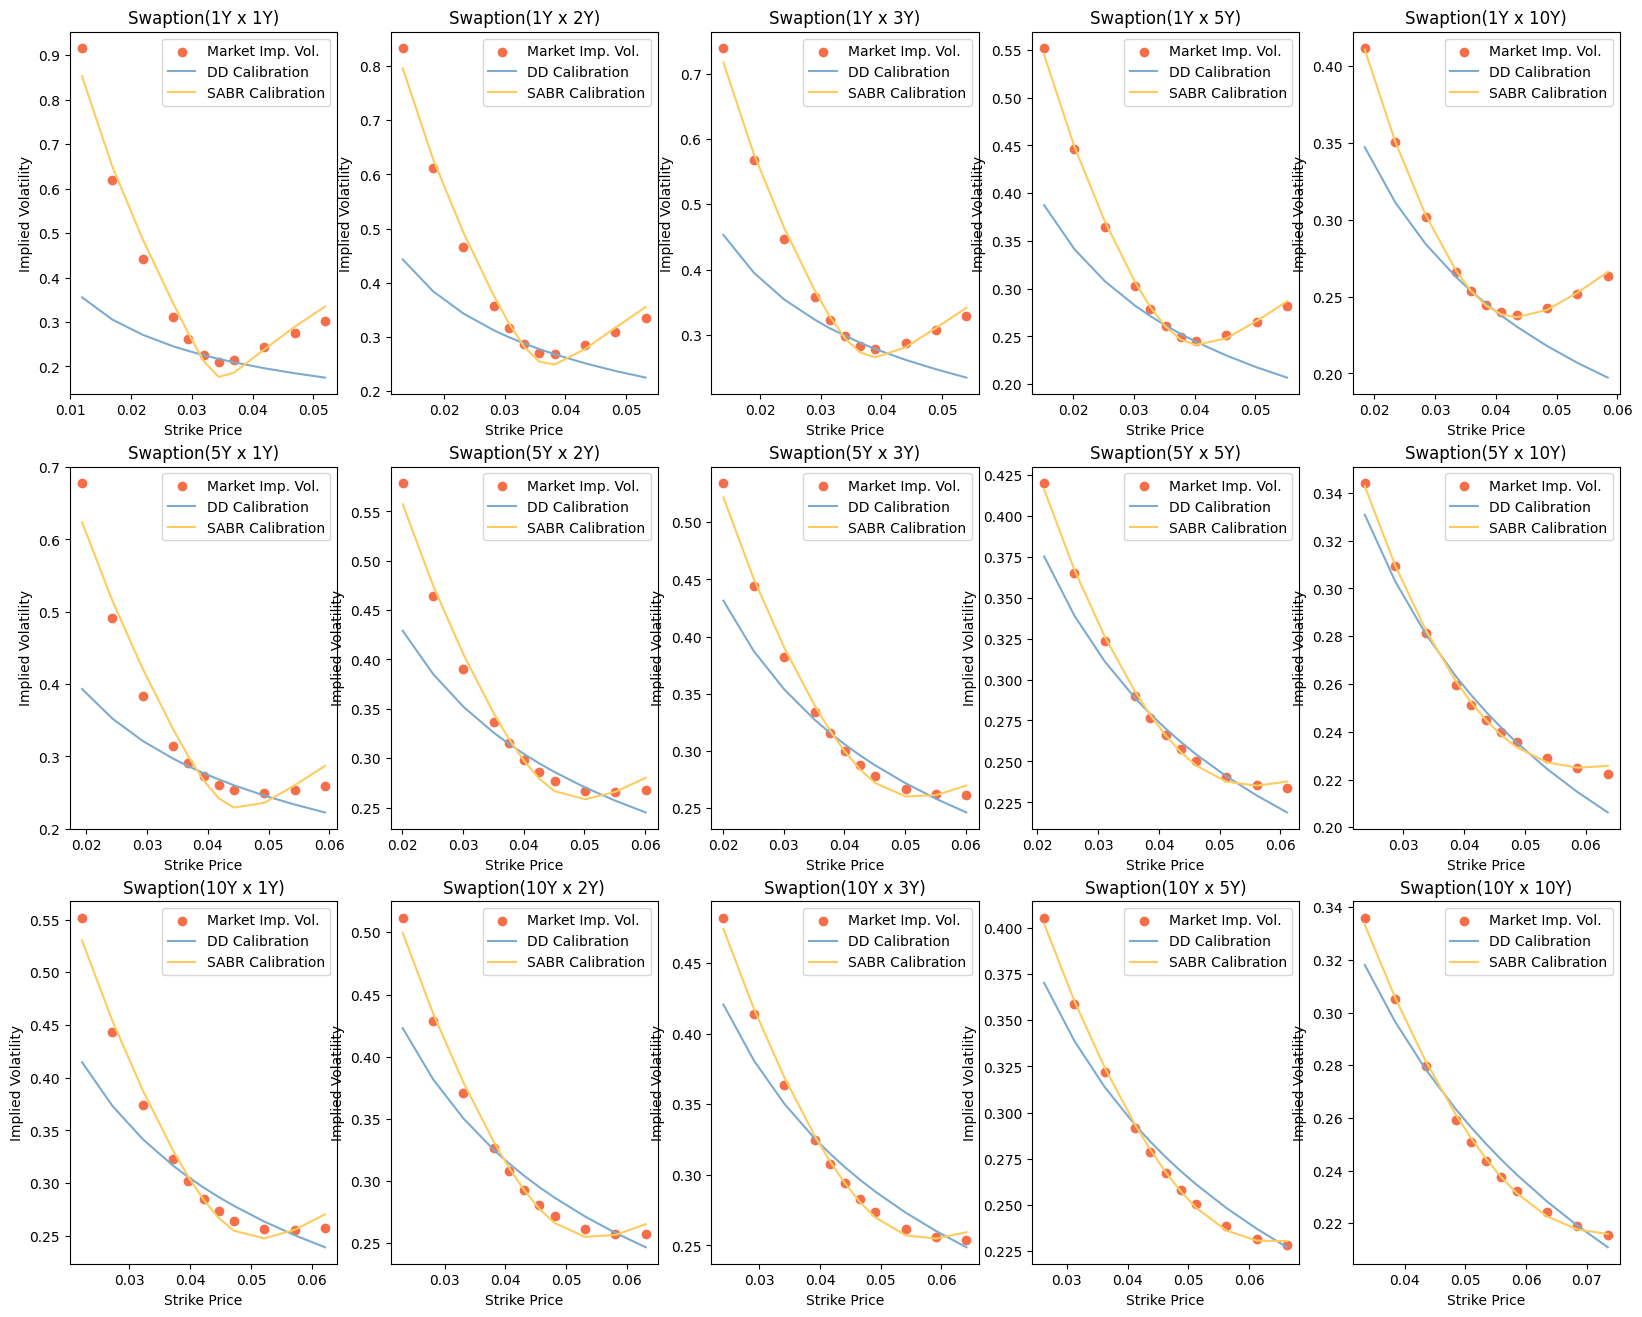

In [30]:
plt.figure(figsize=(20, 16))
for i in range(len(Swaption_data)):
    plt.subplot(3,5,i+1)
    draw_graph(i)

# <a id = "p5">5.</a>  <font color = "green"> Pricing Swaptions </font>  [back to table of contents](#top)

In [31]:
Calibration_parameters_df = pd.DataFrame({"start": swap_data1["Expiry"],
                                        "tenor": swap_data1["Tenor"],
                                        "Beta": beta_list,
                                        "alpha": fsr['alpha'],
                                        "rho": fsr['rho'],
                                        "nu": fsr['nu'],
                                        "sigma": swap_data1["ATM"]/100})

# Calibration_parameters_df

In [32]:
Calibration_parameters_df.to_csv("Calibration_parameters_df.csv",index=False)

In [33]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [34]:
def value_obtain(start,tenor,name):
    SABR_Alpha_10_1 = Calibration_parameters_df[Calibration_parameters_df["start"] == start]
    SABR_Alpha_10_1 = SABR_Alpha_10_1[SABR_Alpha_10_1["tenor"] == tenor][name]
    return float(SABR_Alpha_10_1)

In [35]:
def value_compute(start1,start2,tenor,name,start3):
    y1 = value_obtain(start1,tenor,name)
    y2 = value_obtain(start2,tenor,name)
    return interpol(start1,y1,start2,y2,start3)

### Computing Forward Swap Rates Using Discount Factors

This section constructs a 5x5 forward swap rate table using combinations of expiries and tenors. The forward swap rate is computed as the present value of the floating leg divided by the present value of the fixed leg, using discount factors.

Let the expiries and tenors be:

- Expiries: \(['1Y', '2Y', '5Y', '8Y', '10Y']\)
- Tenors: \(['1Y', '2Y', '3Y', '5Y', '10Y']\)

For each pair \((i, j)\) corresponding to expiry and tenor in years, the forward swap rate is calculated as:

$$
\text{ForwardSwap}_{i,j} = \frac{\sum_{x=2i}^{2(i+j)-1} D^{\text{OIS}}_x \cdot \frac{D^{\text{IRS}}_{x-1} - D^{\text{IRS}}_x}{D^{\text{IRS}}_x}}{0.5 \cdot \sum_{x=2i}^{2(i+j)-1} D^{\text{OIS}}_x}
$$

Where:
- \( $D^{\text{OIS}}_x$ \) is the OIS discount factor at index \(x\)
- \( $D^{\text{IRS}}_x$ \) is the IRS discount factor at index \(x\)

The numerator aggregates the adjusted floating leg cash flows, while the denominator represents the PVBP (present value of a basis point) of the fixed leg assuming semiannual payments (hence the 0.5 multiplier).

In [36]:
Expiry = ['1Y', "2Y",'5Y','8Y', '10Y']
Tenor = ['1Y', "2Y", '3Y', '5Y','10Y']

fsw = []
for ex in Expiry:
    for te in Tenor:
        i = int(ex.strip()[:-1])
        j = int(te.strip()[:-1])
        deno = 0.5*sum(Discount_Factors.OIS_Discount_Factor[2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            no = Discount_Factors.OIS_Discount_Factor[x] * (Discount_Factors.IRS_Discount_Factor[x-1] - Discount_Factors.IRS_Discount_Factor[x])/Discount_Factors.IRS_Discount_Factor[x]
            terms.append(no)
        numer = sum(terms)
        
        fsw.append(numer/deno)

fsw_array = np.array(fsw).reshape(5, 5)
forward_swap = pd.DataFrame(fsw_array, columns = Tenor, index = Expiry)
forward_swap

,1Y,2Y,3Y,5Y,10Y
1Y,0.031922,0.033217,0.033982,0.035238,0.038419
2Y,0.034516,0.035018,0.035018,0.037027,0.039634
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
8Y,0.041740,0.042646,0.042495,0.043512,0.048711
10Y,0.042190,0.043116,0.044097,0.046249,0.053458


In [37]:
def Black76_Call(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76_Put(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, PVBP, beta, T):   
    return Black76_Call(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

def DD_Put(F, K, sigma, PVBP, beta, T):
    return Black76_Put(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

# <a id = "p5a">5a.</a>  <font color = "green"> Payer 2y x 10y </font>  [back to table of contents](#top)

In [38]:
dd_sigma_2_10 = value_compute(1,5,10,"sigma",2)
dd_Beta_2_10 = value_compute(1,5,10,"Beta",2)
SABR_Alpha_2_10 = value_compute(1,5,10,"alpha",2)
SABR_nu_2_10 = value_compute(1,5,10,"nu",2)
SABR_Rho_2_10 = value_compute(1,5,10,"rho",2)

print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_2_10, 4))
print('Beta, β:', round(dd_Beta_2_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_2_10, 4))
print('Nu, ν:', round(SABR_nu_2_10, 4))
print('Rho, ρ:', round(SABR_Rho_2_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2448
Beta, β: 0.0145
SABR Model
Alpha, α: 0.1712
Nu, ν: 0.7218
Rho, ρ: -0.2957


In [39]:
fwd1 = forward_swap.iloc[1,-1]
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = calc_pvbp(2, 12)

In [40]:
payer_DD = [DD_Call(fwd1, 
                    i, 
                    dd_sigma_2_10, 
                    pvbp1, 
                    dd_Beta_2_10, 
                    T) for i in strikes]  


 
payer_SABR=[Black76_Call(fwd1,
                         i,
                         SABR(fwd1,i,T,SABR_Alpha_2_10,0.9,SABR_Rho_2_10,SABR_nu_2_10),
                         pvbp1,
                         T) for i in strikes]

In [41]:
payer_2x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR}).T

payer_2x10.columns=payer_2x10.iloc[0]
payer_2x10 = payer_2x10.drop(['Strikes'], axis = 0)
payer_2x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.288134,0.194929,0.112321,0.051344,0.017369,0.004109,0.000652,0.000068
SABR,0.289685,0.198398,0.115127,0.051959,0.021480,0.011045,0.006963,0.004972


# <a id = "p5b">5b.</a>  <font color = "green"> Receiver 8y x 10y </font>  [back to table of contents](#top)

In [42]:
dd_sigma_8_10 = value_compute(5,10,10,"sigma",8)
dd_Beta_8_10 = value_compute(5,10,10,"Beta",8)
SABR_Alpha_8_10 = value_compute(5,10,10,"alpha",8)
SABR_nu_8_10 = value_compute(5,10,10,"nu",8)
SABR_Rho_8_10 = value_compute(5,10,10,"rho",8)


print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_8_10, 4))
print('Beta, β:', round(dd_Beta_8_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_8_10, 4))
print('Nu, ν:', round(SABR_nu_8_10, 4))
print('Rho, ρ:', round(SABR_Rho_8_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2443
Beta, β: 0.0235
SABR Model
Alpha, α: 0.1781
Nu, ν: 0.5527
Rho, ρ: -0.4713


In [43]:
fwd2 = forward_swap.iloc[3,-1]
pvbp2 = calc_pvbp(8, 18)
T2 = 8

In [44]:
rec_DD = [DD_Put(fwd2, 
                 i, 
                 dd_sigma_8_10, 
                 pvbp2, 
                 dd_Beta_8_10, 
                 T2) for i in strikes]   

rec_SABR=[Black76_Put(fwd2,
                      i,
                      SABR(fwd2,i,T2,SABR_Alpha_8_10,0.9,SABR_Rho_8_10,SABR_nu_8_10)
                      ,pvbp2,
                      T2) for i in strikes]

In [45]:
receiver_8x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR}).T

receiver_8x10.columns=receiver_8x10.iloc[0]
receiver_8x10 = receiver_8x10.drop(['Strikes'], axis = 0)
receiver_8x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.018977,0.033895,0.056639,0.088971,0.132041,0.186126,0.250570,0.323955
SABR,0.019701,0.038960,0.061552,0.090476,0.130438,0.186456,0.258093,0.339619
